<div class="alert alert-block alert-info">
<strong>Name and surname:


**Neil de la Fuente**</strong>
</div>


# Part 4. Cluster-then-label

Cluster-then-label approaches form a group of methods that **explicitly join** the clustering and classification processes: they first apply an unsupervised or semi-supervised clustering algorithm to all available data, and use the resulting clusters to guide the classification process.

A simple example of a Cluster-then-label method:
- Cluster the data in a semi-supervised manner, favouring clusters with limited label impurity (i.e. a high degree of consistency in the labels of the data points within a given cluster),
- The unlabelled data points are then mapped, yielding a cluster assignment for each of them.
- If the cluster to which an unlabelled data point $x_i$ is mapped contains only data points with the same label, that label is also assigned to $x_i$.
- This process can be iterated, after which the resulting label assignments can be used to train a supervised classifier.

<u>Questions</u> (**3 points**):
1. Implement (manually) a function to apply the cluster-then-label algorithm, as previously stated.
- Use the same CNN from the aforementioned exercises.
- For each iteration, you must provide (at least) the following information:
  - The number of items added to the labelled data
  - The number of correctly / incorrectly classified items that are added to the labelled data
2. Try at least two different clustering algorithms and choose the best. Justify your decision.
3. With the best clustering algorithm, report the same evaluation metrics.

**Notes**:
- **DO NOT USE** any third-party implementation.

In [ ]:
#@title Necessary imports

import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, Dataset, random_split, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin_min
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.datasets import fetch_openml
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans

## Semi-supervised Clustering:

### Data preparation

In [ ]:
# Fetch FashionMNIST dataset (this is just another way to upload fashion mnist that I was trying)
mnist = fetch_openml('Fashion-MNIST')
X = np.array(mnist['data'])
y = np.array(mnist['target']).astype(int)


#get the 10k labelled datapoints and the 50k that are yet to be labelled semisupervisedly
DL_features = X[:10000]
DL_actual_labels = y[:10000]
DU_features = X[10000:60000]
DU_actual_labels = y[10000:60000]

DL_features_kmeans = DL_features.copy()
DL_actual_labels_kmeans = DL_actual_labels.copy()
DU_features_kmeans = DU_features.copy()
DU_actual_labels_kmeans = DU_actual_labels.copy()

DL_features_gmm = DL_features.copy()
DL_actual_labels_gmm = DL_actual_labels.copy()
DU_features_gmm = DU_features.copy()
DU_actual_labels_gmm = DU_actual_labels.copy()

DL_features_mbkmeans = DL_features.copy()
DL_actual_labels_mbkmeans = DL_actual_labels.copy()
DU_features_mbkmeans = DU_features.copy()
DU_actual_labels_mbkmeans = DU_actual_labels.copy()


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### Helper function

In [ ]:
# Function to update cluster-to-label mapping
def update_cluster_to_label_mapping(kmeans, DL_actual_labels):
    label_count = Counter()
    for i in range(len(DL_actual_labels)):
        cluster_id = kmeans.labels_[i]
        class_label = DL_actual_labels[i]
        label_count[cluster_id] = label_count.get(cluster_id, Counter())
        label_count[cluster_id][class_label] += 1

    cluster_to_label_mapping = {}
    for cluster_id, counts in label_count.items():
        cluster_to_label_mapping[cluster_id] = counts.most_common(1)[0][0]

    return cluster_to_label_mapping

### kmeans

In [ ]:
def run_kmeans(DL_features, DL_actual_labels, DU_features, DU_actual_labels):
    # Initialize K-means
    kmeans = KMeans(n_clusters=10, n_init=10)
    kmeans.fit(DL_features)

    cluster_to_label_mapping = update_cluster_to_label_mapping(kmeans, DL_actual_labels)

    # Initialize PCA
    pca = PCA(n_components=2)
    all_features_pca = pca.fit_transform(np.concatenate([DL_features, DU_features]))

    for iteration in range(7):
        # Check if DU_features is empty
        if DU_features.shape[0] == 0:
            print("No more unlabelled samples.")
            break

        # Plotting
        print(f"Iteration {iteration + 1}:")
        print(f"Number of items added to the labeled set: 10000")

        plt.figure(figsize=(12, 8))
        for cluster_id, label in cluster_to_label_mapping.items():
            indices = np.where(kmeans.labels_ == cluster_id)[0]
            plt.scatter(all_features_pca[indices, 0], all_features_pca[indices, 1], label=f'Class {label}', alpha=0.5)

        plt.scatter(all_features_pca[len(DL_features):, 0], all_features_pca[len(DL_features):, 1], color='lightgray', label='Unlabelled', alpha=0.2)
        plt.legend()
        plt.title(f"Iteration {iteration + 1}")
        plt.show()

        #Clustering and label assignment for DU
        DU_cluster_labels = kmeans.predict(DU_features)
        distances = np.linalg.norm(DU_features - kmeans.cluster_centers_[DU_cluster_labels], axis=1)
        closest_indices = np.argsort(distances)[:10000]

        #Check if there are enough samples for the next step
        if closest_indices.shape[0] == 0:
            print("No more samples to add.")
            break

        # Update labels and actual labels
        DU_new_labels = [cluster_to_label_mapping[DU_cluster_labels[i]] for i in closest_indices]
        correct_labels = np.sum(np.array(DU_new_labels) == np.array(DU_actual_labels[closest_indices]))
        incorrect_labels = 10000 - correct_labels


        print(f"Correctly classified: {correct_labels}")
        print(f"Incorrectly classified: {incorrect_labels}")

        # Update DL and DU datasets
        DL_features = np.vstack([DL_features, DU_features[closest_indices]])
        DL_actual_labels = np.concatenate([DL_actual_labels, DU_actual_labels[closest_indices]])

        DU_features = np.delete(DU_features, closest_indices, axis=0)
        DU_actual_labels = np.delete(DU_actual_labels, closest_indices)

        # Update K-means and cluster-to-label mapping
        kmeans = KMeans(n_clusters=10, n_init=10)
        kmeans.fit(DL_features)
        cluster_to_label_mapping = update_cluster_to_label_mapping(kmeans, DL_actual_labels)

    #Change name for better understanding
    semisupervised_labels_kmeans = DL_actual_labels

    return semisupervised_labels_kmeans



### Mini-Batch Kmeans

In [ ]:
def run_mbkmeans(DL_features, DL_actual_labels, DU_features, DU_actual_labels):
    # Initialize Mini-Batch K-means
    mbkmeans = MiniBatchKMeans(n_clusters=10, n_init=10, batch_size=100)
    mbkmeans.fit(DL_features)

    cluster_to_label_mapping = update_cluster_to_label_mapping(mbkmeans, DL_actual_labels)

    # Initialize PCA
    pca = PCA(n_components=2)
    all_features_pca = pca.fit_transform(np.concatenate([DL_features, DU_features]))

    for iteration in range(7):
        # Check if DU_features is empty
        if DU_features.shape[0] == 0:
            print("No more unlabelled samples.")
            break

        # Plotting
        print(f"Iteration {iteration + 1}:")
        print(f"Number of items added to the labeled set: 10000")

        plt.figure(figsize=(12, 8))
        for cluster_id, label in cluster_to_label_mapping.items():
            indices = np.where(mbkmeans.labels_ == cluster_id)[0]
            plt.scatter(all_features_pca[indices, 0], all_features_pca[indices, 1], label=f'Class {label}', alpha=0.5)

        plt.scatter(all_features_pca[len(DL_features):, 0], all_features_pca[len(DL_features):, 1], color='lightgray', label='Unlabelled', alpha=0.2)
        plt.legend()
        plt.title(f"Iteration {iteration + 1}")
        plt.show()

        #Clustering and label assignment for DU
        DU_cluster_labels = mbkmeans.predict(DU_features)
        distances = np.linalg.norm(DU_features - mbkmeans.cluster_centers_[DU_cluster_labels], axis=1)
        closest_indices = np.argsort(distances)[:10000]

        #Check if there are enough samples for the next step
        if closest_indices.shape[0] == 0:
            print("No more samples to add.")
            break

        # Update labels and actual labels
        DU_new_labels = [cluster_to_label_mapping[DU_cluster_labels[i]] for i in closest_indices]
        correct_labels = np.sum(np.array(DU_new_labels) == np.array(DU_actual_labels[closest_indices]))
        incorrect_labels = 10000 - correct_labels


        print(f"Correctly classified: {correct_labels}")
        print(f"Incorrectly classified: {incorrect_labels}")

        # Update DL and DU datasets
        DL_features = np.vstack([DL_features, DU_features[closest_indices]])
        DL_actual_labels = np.concatenate([DL_actual_labels, DU_actual_labels[closest_indices]])

        DU_features = np.delete(DU_features, closest_indices, axis=0)
        DU_actual_labels = np.delete(DU_actual_labels, closest_indices)

        # Update Mini-Batch K-means and cluster-to-label mapping
        mbkmeans = MiniBatchKMeans(n_clusters=10, n_init=10, batch_size=100)
        mbkmeans.fit(DL_features)
        cluster_to_label_mapping = update_cluster_to_label_mapping(mbkmeans, DL_actual_labels)

    #Change name for better understanding
    semisupervised_labels_mbkmeans = DL_actual_labels

    return semisupervised_labels_mbkmeans


### Evaluating clustering methods

Iteration 1:
Number of items added to the labeled set: 10000


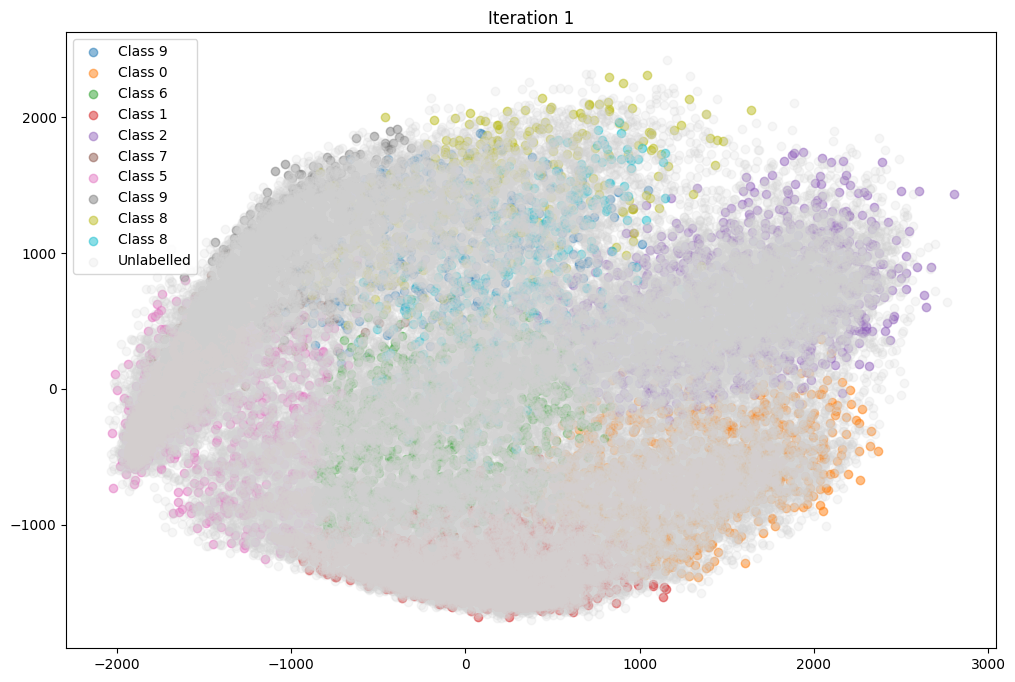

Correctly classified: 6410
Incorrectly classified: 3590
Iteration 2:
Number of items added to the labeled set: 10000


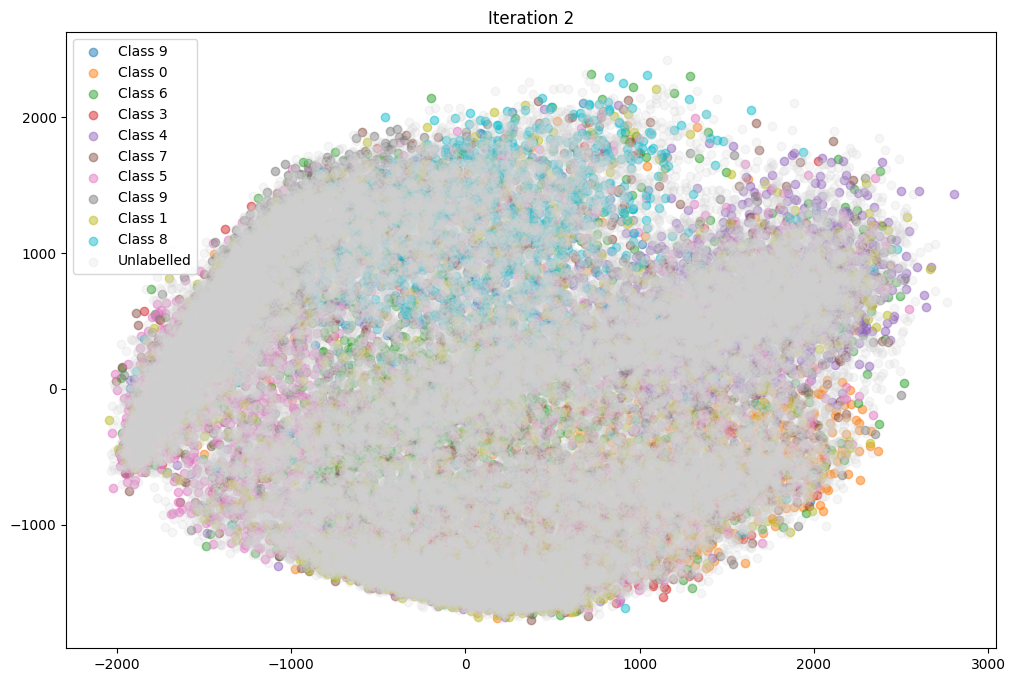

Correctly classified: 6837
Incorrectly classified: 3163
Iteration 3:
Number of items added to the labeled set: 10000


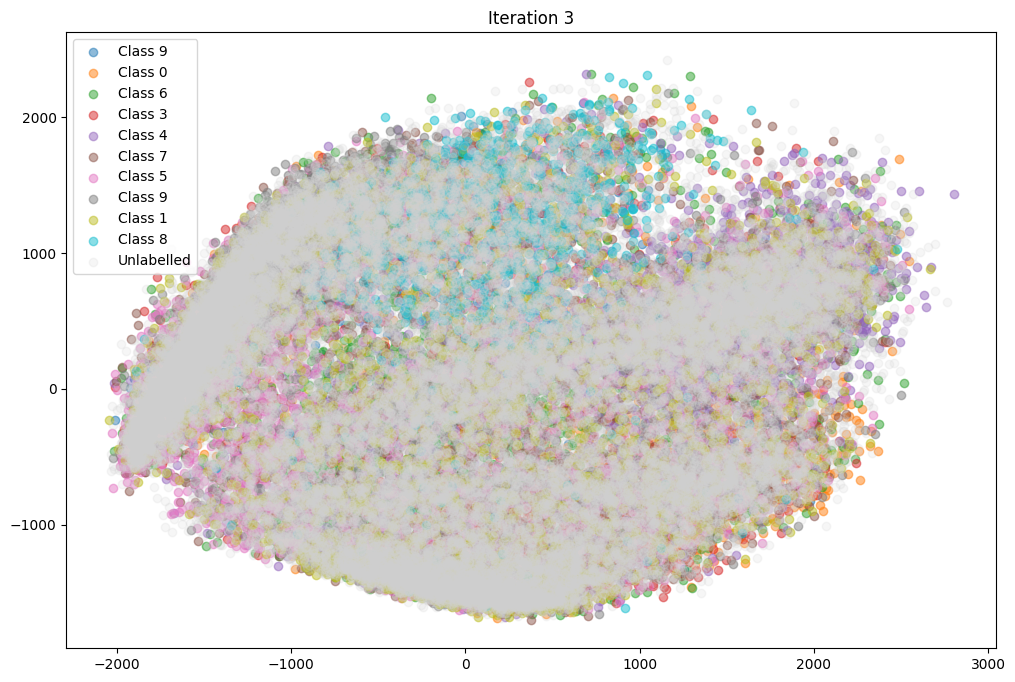

Correctly classified: 6189
Incorrectly classified: 3811
Iteration 4:
Number of items added to the labeled set: 10000


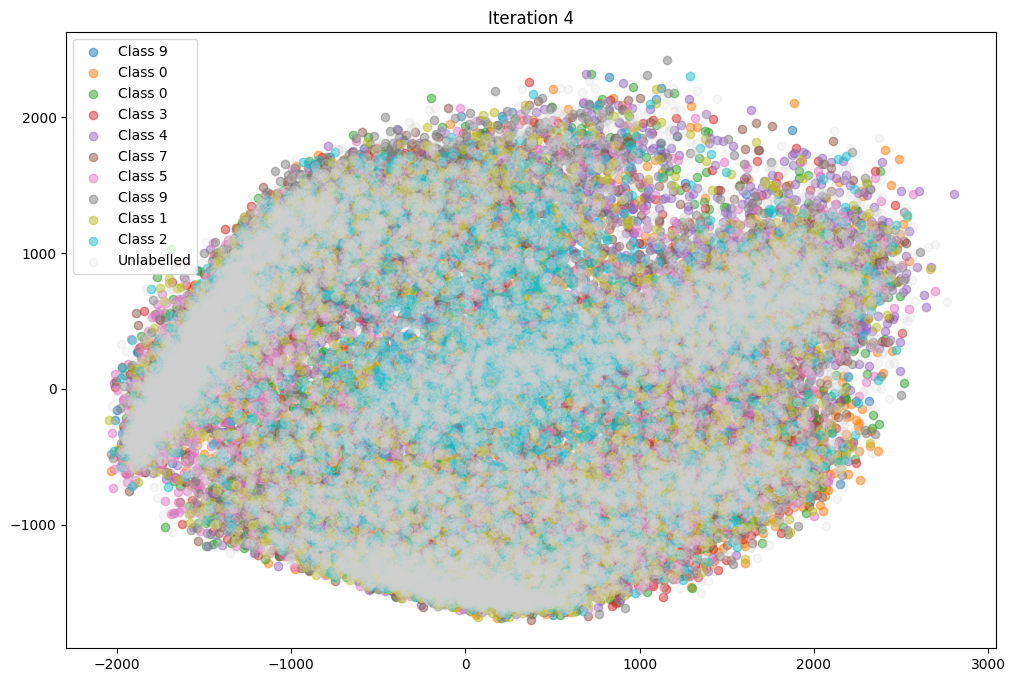

Correctly classified: 5129
Incorrectly classified: 4871
Iteration 5:
Number of items added to the labeled set: 10000


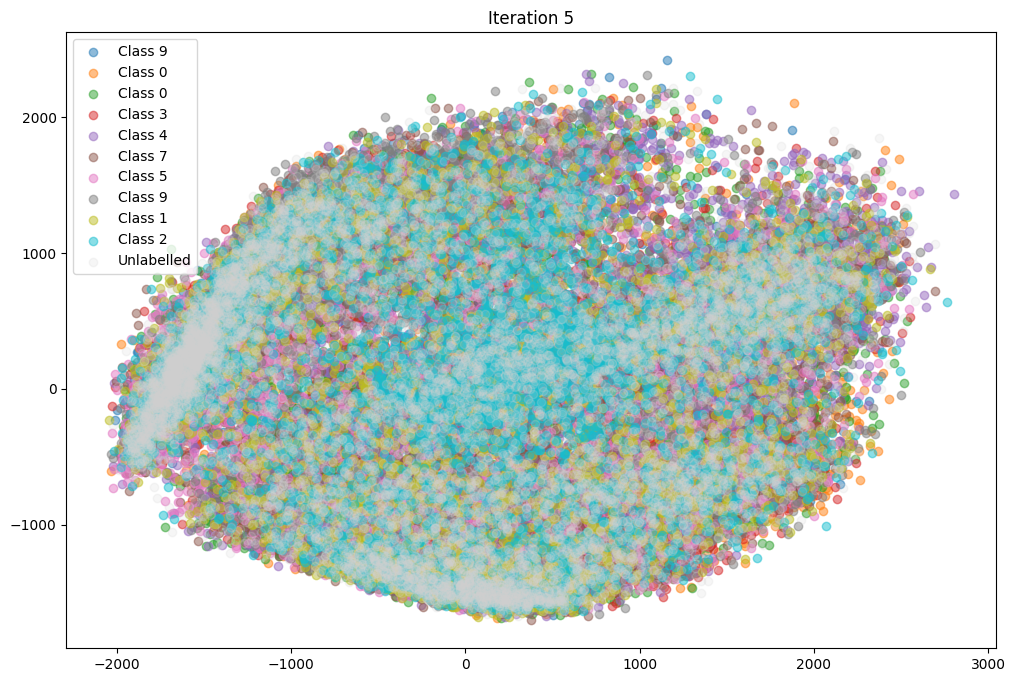

Correctly classified: 2795
Incorrectly classified: 7205
No more unlabelled samples.


In [ ]:
# Running K-means
semisupervised_labels_kmeans = run_kmeans(
    DL_features_kmeans,
    DL_actual_labels_kmeans,
    DU_features_kmeans,
    DU_actual_labels_kmeans
)

Iteration 1:
Number of items added to the labeled set: 10000


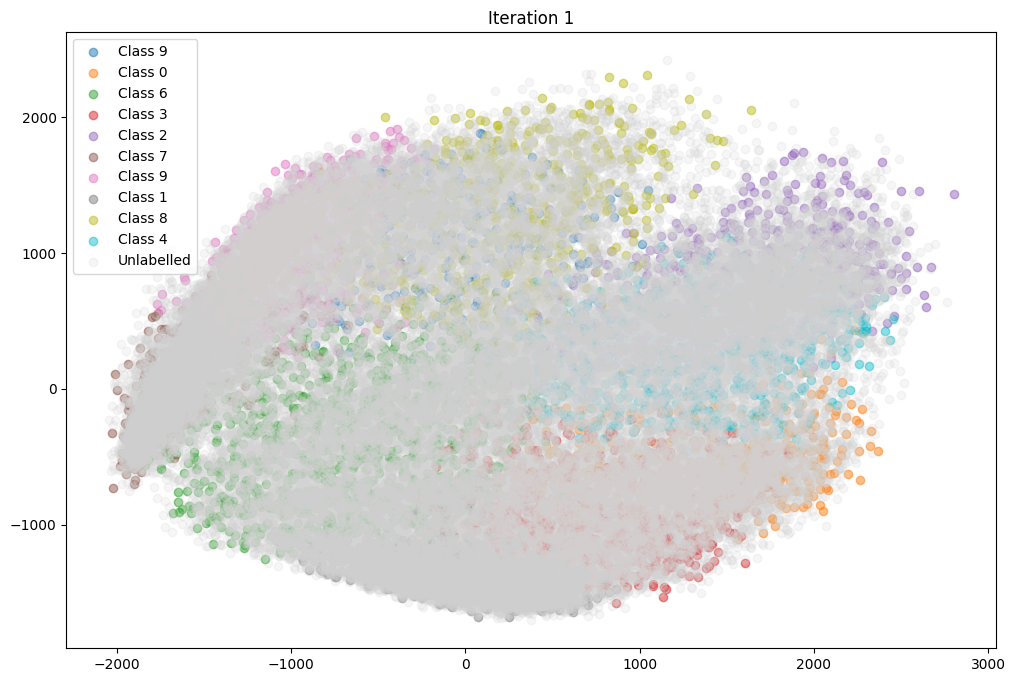

Correctly classified: 7306
Incorrectly classified: 2694
Iteration 2:
Number of items added to the labeled set: 10000


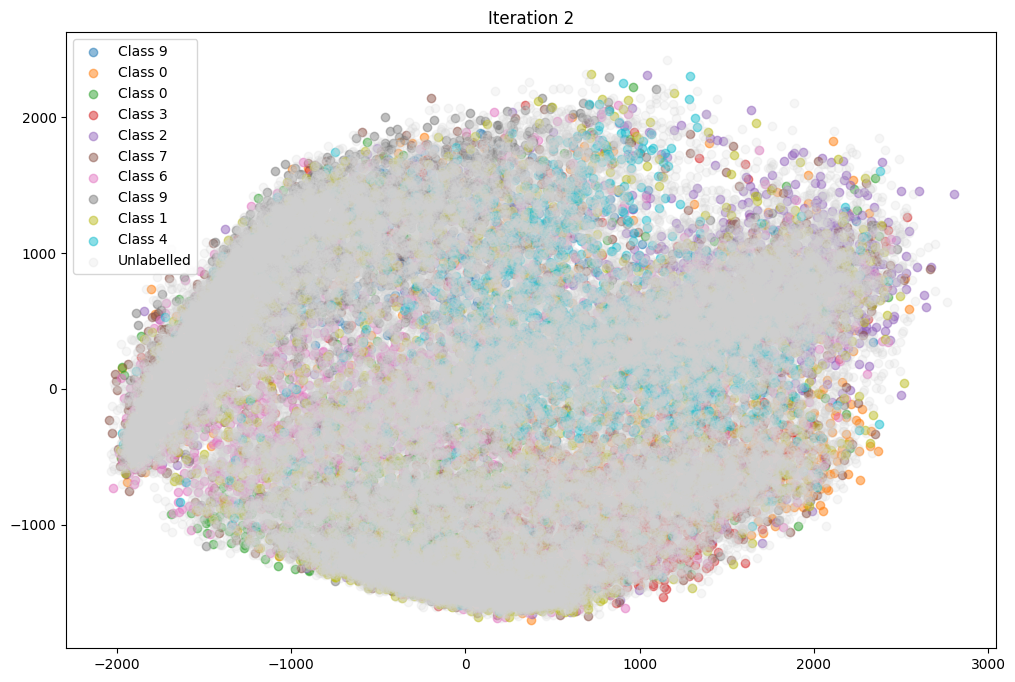

Correctly classified: 5729
Incorrectly classified: 4271
Iteration 3:
Number of items added to the labeled set: 10000


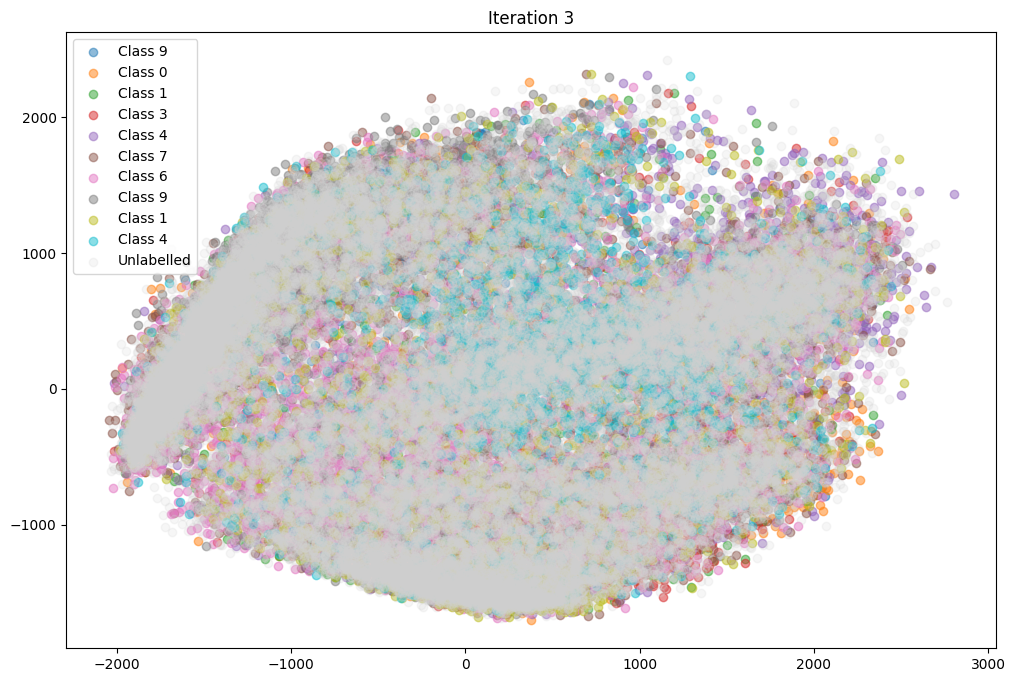

Correctly classified: 5152
Incorrectly classified: 4848
Iteration 4:
Number of items added to the labeled set: 10000


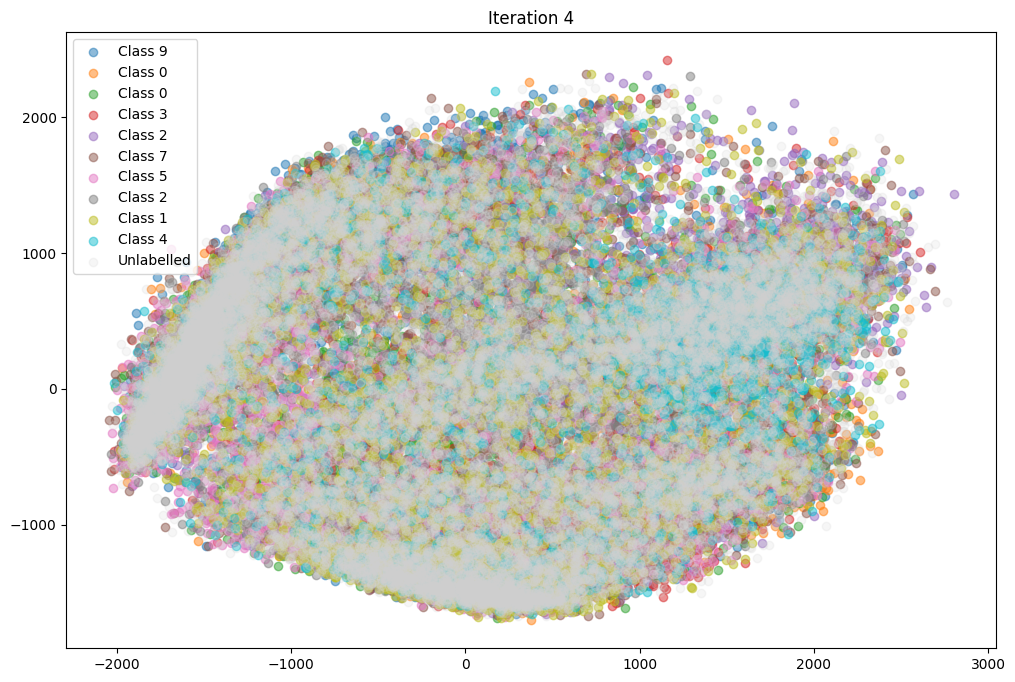

Correctly classified: 5710
Incorrectly classified: 4290
Iteration 5:
Number of items added to the labeled set: 10000


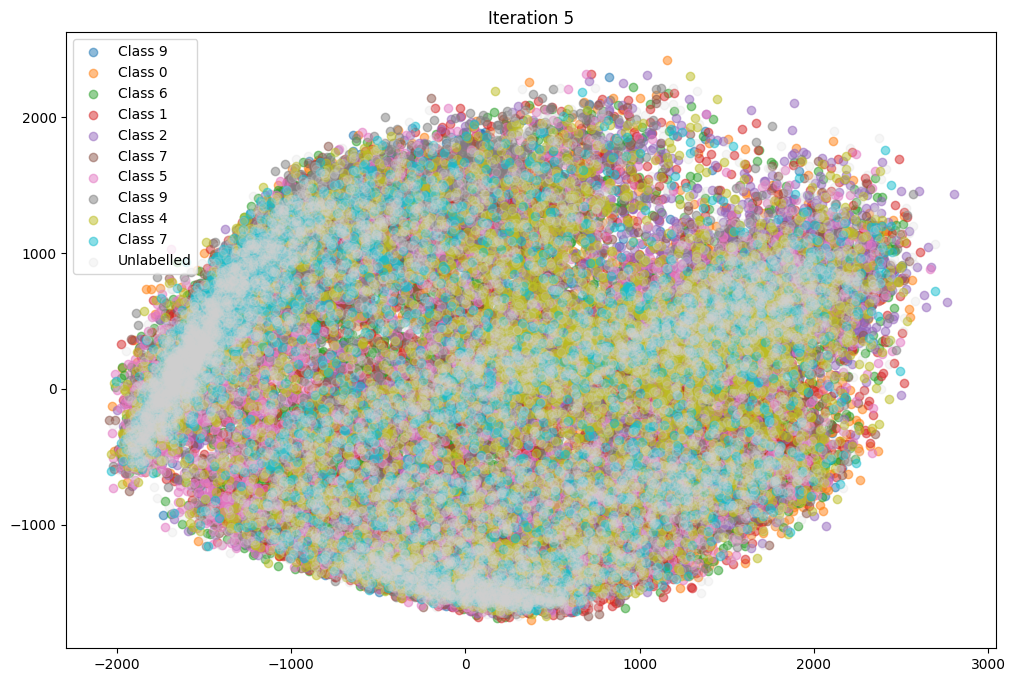

Correctly classified: 3093
Incorrectly classified: 6907
No more unlabelled samples.


In [ ]:
# Running MBK-means
semisupervised_labels_mbkmeans = run_mbkmeans(
    DL_features_mbkmeans,
    DL_actual_labels_mbkmeans,
    DU_features_mbkmeans,
    DU_actual_labels_mbkmeans
)

## Classification on the dataset built by the semi-supervised clustering.

We´ll use the kmeans generated labels bcs they are more accurate compared with the actual labels. This is normal as MBkmeans is an speed-up version of kmeans and hence it is usually worse in performance.

In [ ]:
#This CustomFashionMNIST dataset class is for being able to use the labels assigned
#by the Clustering method, That´s the only thing I change.
class CustomFashionMNIST(datasets.FashionMNIST):
    def __init__(self, *args, new_labels=None, **kwargs):
        super(CustomFashionMNIST, self).__init__(*args, **kwargs)
        if new_labels is not None:
            assert len(new_labels) == len(self)
            self.targets = torch.tensor(new_labels, dtype=torch.int64)

    def __getitem__(self, index):
        img, _ = super(CustomFashionMNIST, self).__getitem__(index)
        target = self.targets[index]
        return img, target


train_dataset = CustomFashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor(), new_labels=semisupervised_labels_kmeans)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

print(f"Training data shape: {len(train_dataset)}")
print(f"Testing data shape: {len(test_dataset)}")


100%|██████████| 26421880/26421880 [00:00<00:00, 114618122.27it/s]


Extracting ./data/CustomFashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/CustomFashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4919523.23it/s]

Extracting ./data/CustomFashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/CustomFashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 55340319.45it/s]


Extracting ./data/CustomFashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/CustomFashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8395131.02it/s]


Extracting ./data/CustomFashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/CustomFashionMNIST/raw



100%|██████████| 26421880/26421880 [00:00<00:00, 113617990.18it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 6436921.93it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 60201628.43it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19007286.08it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training data shape: 60000
Testing data shape: 10000


In [ ]:
# @title auxiliary function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(CNN, self).__init__()

        self.conv = nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=(5,5)) #[batch_size, n_channels, 24, 24] (28 - 5 + 1 = 24)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2)) #[batch_size, n_channels, 12, 12] (24 / 2 = 12)

        # Calculate in_features after flattening
        self.in_features_after_flatten = n_channels * 12 * 12
        self.fc = nn.Linear(in_features=self.in_features_after_flatten, out_features=n_classes)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Flatten the tensor
        x = x.view(x.size(0), self.in_features_after_flatten)
        x = self.fc(x)
        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
learning_rate = 3e-3
lambda_l2 = 1e-5
momentum = 0.9
torch.manual_seed(42) # seed set to 42 bcs I like the number

n_classes = 10  # there are 10 classes
n_channels = 16

model = CNN(n_channels, n_classes)

print(f"Number of parameters: {get_n_params(model)}")


model.to(device)


criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=lambda_l2) # built-in L2

Number of parameters: 23466


In [ ]:
#Train and validate function implementations

@torch.no_grad()
def validate(criterion, model, loader):
    val_loss = 0
    model.eval()

    all_preds = []
    all_labels = []

    for data, target in tqdm(loader, desc="Validation", total=len(loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1]
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    val_loss /= len(loader)

    return val_loss, np.array(all_preds).flatten(), np.array(all_labels).flatten()



def train(epoch, criterion, model, optimizer, loader):
    total_loss = 0.0
    model.train()

    # Add tqdm here
    for batch_idx, (data, target) in tqdm(enumerate(loader), desc=f"Training Epoch {epoch+1}", total=len(loader)):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loader.dataset)} ({100. * batch_idx / len(loader):.0f}%)]\tLoss: {loss.item():.6f}')

        total_loss += loss.item()

    return total_loss / len(loader)  # Normalize by number of batches


Training Epoch 1:   1%|▏         | 8/600 [00:08<07:21,  1.34it/s]  

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.307204


Training Epoch 1:  18%|█▊        | 105/600 [00:10<00:10, 45.78it/s]

Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.246305


Training Epoch 1:  35%|███▌      | 210/600 [00:11<00:05, 73.13it/s]

Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.273118


Training Epoch 1:  52%|█████▏    | 310/600 [00:13<00:03, 77.06it/s]

Train Epoch: 0 [30000/60000 (50%)]	Loss: 2.224612


Training Epoch 1:  68%|██████▊   | 409/600 [00:14<00:02, 73.38it/s]

Train Epoch: 0 [40000/60000 (67%)]	Loss: 2.228112


Training Epoch 1:  86%|████████▌ | 516/600 [00:16<00:01, 74.41it/s]

Train Epoch: 0 [50000/60000 (83%)]	Loss: 2.271495


Validation: 100%|██████████| 100/100 [00:01<00:00, 53.83it/s]


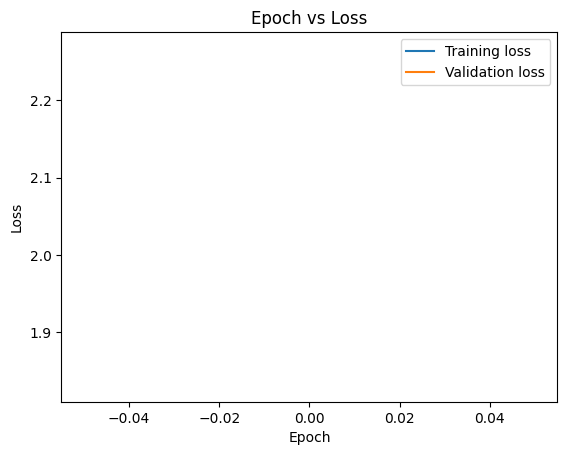

Training Epoch 2:   2%|▏         | 9/600 [00:00<00:14, 41.89it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.196613


Training Epoch 2:  19%|█▉        | 115/600 [00:02<00:07, 66.53it/s]

Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.278143


Training Epoch 2:  35%|███▌      | 212/600 [00:03<00:05, 73.13it/s]

Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.243510


Training Epoch 2:  51%|█████▏    | 308/600 [00:05<00:04, 65.89it/s]

Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.299258


Training Epoch 2:  68%|██████▊   | 409/600 [00:06<00:02, 67.45it/s]

Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.314214


Training Epoch 2:  85%|████████▌ | 511/600 [00:07<00:01, 66.32it/s]

Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.209430


Validation: 100%|██████████| 100/100 [00:01<00:00, 68.25it/s]


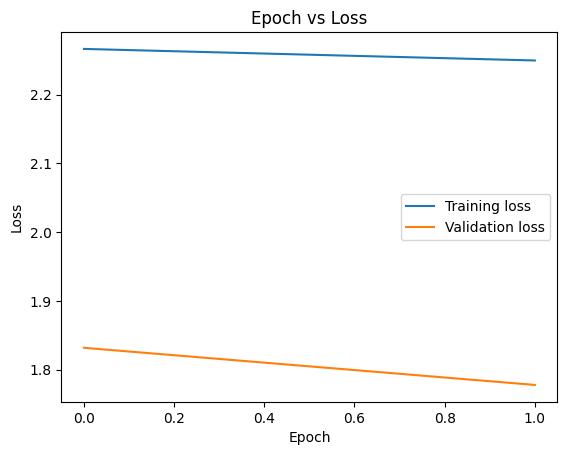

Training Epoch 3:   2%|▏         | 14/600 [00:00<00:08, 65.23it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.267896


Training Epoch 3:  18%|█▊        | 105/600 [00:02<00:10, 45.48it/s]

Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.288393


Training Epoch 3:  35%|███▍      | 208/600 [00:04<00:05, 66.93it/s]

Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.269805


Training Epoch 3:  52%|█████▏    | 309/600 [00:05<00:04, 71.71it/s]

Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.215486


Training Epoch 3:  69%|██████▊   | 412/600 [00:06<00:02, 69.00it/s]

Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.160878


Training Epoch 3:  84%|████████▍ | 507/600 [00:08<00:01, 66.70it/s]

Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.226665


Validation: 100%|██████████| 100/100 [00:01<00:00, 67.47it/s]


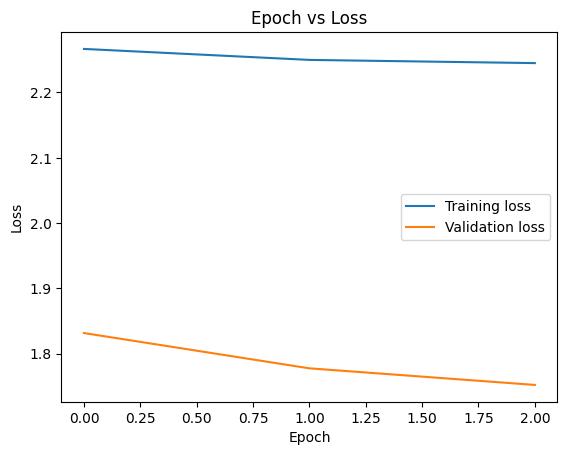

Training Epoch 4:   2%|▏         | 14/600 [00:00<00:08, 68.44it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.277620


Training Epoch 4:  19%|█▊        | 112/600 [00:01<00:07, 62.29it/s]

Train Epoch: 3 [10000/60000 (17%)]	Loss: 2.203888


Training Epoch 4:  35%|███▍      | 209/600 [00:03<00:08, 45.59it/s]

Train Epoch: 3 [20000/60000 (33%)]	Loss: 2.292682


Training Epoch 4:  52%|█████▏    | 312/600 [00:05<00:04, 70.09it/s]

Train Epoch: 3 [30000/60000 (50%)]	Loss: 2.245832


Training Epoch 4:  68%|██████▊   | 408/600 [00:06<00:02, 68.16it/s]

Train Epoch: 3 [40000/60000 (67%)]	Loss: 2.244156


Training Epoch 4:  86%|████████▌ | 513/600 [00:08<00:01, 64.76it/s]

Train Epoch: 3 [50000/60000 (83%)]	Loss: 2.270496


Validation: 100%|██████████| 100/100 [00:01<00:00, 66.63it/s]


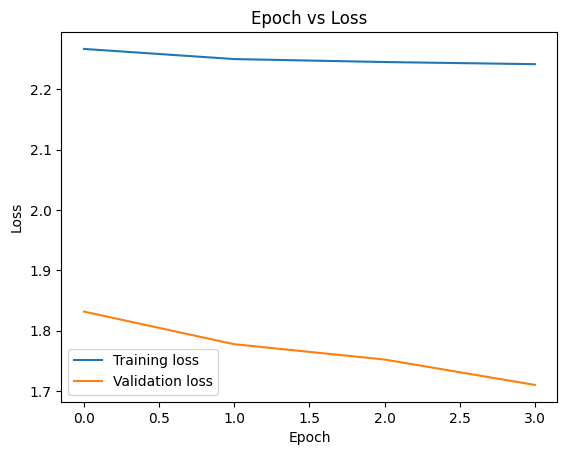

Training Epoch 5:   2%|▏         | 14/600 [00:00<00:08, 65.53it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.265539


Training Epoch 5:  18%|█▊        | 109/600 [00:01<00:07, 67.12it/s]

Train Epoch: 4 [10000/60000 (17%)]	Loss: 2.262777


Training Epoch 5:  35%|███▍      | 208/600 [00:03<00:06, 62.41it/s]

Train Epoch: 4 [20000/60000 (33%)]	Loss: 2.254815


Training Epoch 5:  52%|█████▏    | 309/600 [00:05<00:06, 46.14it/s]

Train Epoch: 4 [30000/60000 (50%)]	Loss: 2.231894


Training Epoch 5:  68%|██████▊   | 410/600 [00:07<00:02, 68.72it/s]

Train Epoch: 4 [40000/60000 (67%)]	Loss: 2.245018


Training Epoch 5:  85%|████████▌ | 512/600 [00:08<00:01, 67.92it/s]

Train Epoch: 4 [50000/60000 (83%)]	Loss: 2.262579


Validation: 100%|██████████| 100/100 [00:01<00:00, 64.25it/s]


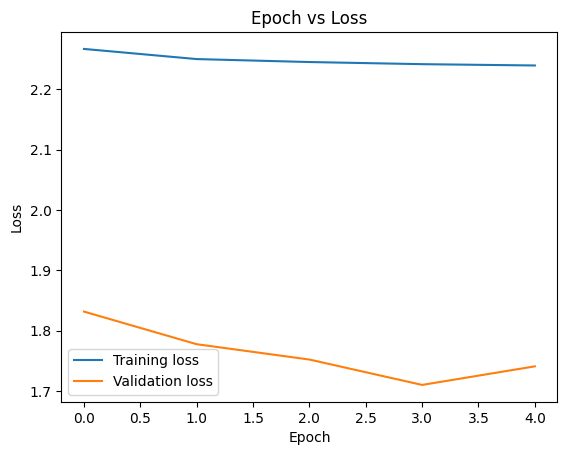

Training Epoch 6:   2%|▏         | 13/600 [00:00<00:09, 62.53it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.248604


Training Epoch 6:  18%|█▊        | 107/600 [00:01<00:07, 65.81it/s]

Train Epoch: 5 [10000/60000 (17%)]	Loss: 2.230824


Training Epoch 6:  35%|███▌      | 211/600 [00:03<00:05, 66.76it/s]

Train Epoch: 5 [20000/60000 (33%)]	Loss: 2.234631


Training Epoch 6:  51%|█████     | 305/600 [00:05<00:06, 44.41it/s]

Train Epoch: 5 [30000/60000 (50%)]	Loss: 2.289161


Training Epoch 6:  68%|██████▊   | 408/600 [00:07<00:02, 67.93it/s]

Train Epoch: 5 [40000/60000 (67%)]	Loss: 2.244887


Training Epoch 6:  85%|████████▍ | 509/600 [00:09<00:01, 68.45it/s]

Train Epoch: 5 [50000/60000 (83%)]	Loss: 2.256381


Validation: 100%|██████████| 100/100 [00:01<00:00, 67.74it/s]


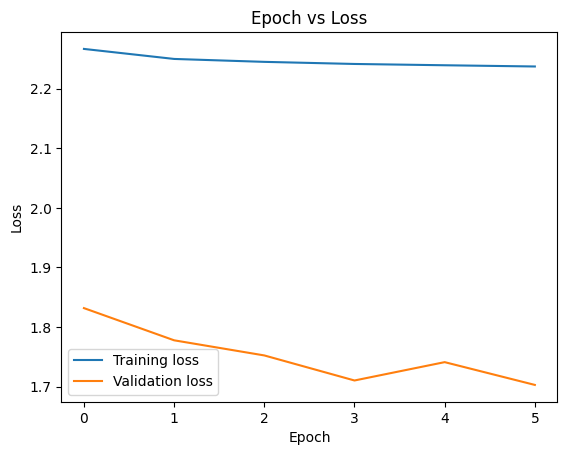

Training Epoch 7:   2%|▏         | 13/600 [00:00<00:09, 61.54it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.211225


Training Epoch 7:  18%|█▊        | 110/600 [00:01<00:07, 68.92it/s]

Train Epoch: 6 [10000/60000 (17%)]	Loss: 2.101163


Training Epoch 7:  34%|███▍      | 203/600 [00:03<00:07, 52.00it/s]

Train Epoch: 6 [20000/60000 (33%)]	Loss: 2.296289


Training Epoch 7:  51%|█████     | 304/600 [00:07<00:12, 23.44it/s]

Train Epoch: 6 [30000/60000 (50%)]	Loss: 2.288971


Training Epoch 7:  68%|██████▊   | 405/600 [00:10<00:07, 26.30it/s]

Train Epoch: 6 [40000/60000 (67%)]	Loss: 2.237949


Training Epoch 7:  85%|████████▍ | 508/600 [00:13<00:02, 41.08it/s]

Train Epoch: 6 [50000/60000 (83%)]	Loss: 2.200841


Validation: 100%|██████████| 100/100 [00:02<00:00, 39.14it/s]


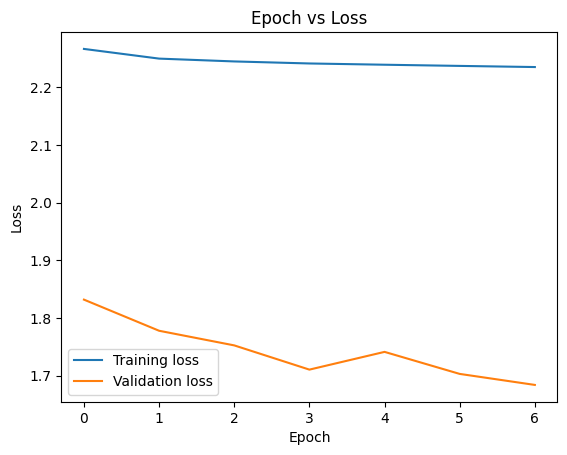

Training Epoch 8:   1%|          | 5/600 [00:00<00:12, 48.77it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 2.210749


Training Epoch 8:  18%|█▊        | 107/600 [00:02<00:13, 37.75it/s]

Train Epoch: 7 [10000/60000 (17%)]	Loss: 2.286711


Training Epoch 8:  34%|███▍      | 206/600 [00:04<00:07, 53.95it/s]

Train Epoch: 7 [20000/60000 (33%)]	Loss: 2.244162


Training Epoch 8:  52%|█████▏    | 312/600 [00:06<00:04, 61.74it/s]

Train Epoch: 7 [30000/60000 (50%)]	Loss: 2.256933


Training Epoch 8:  69%|██████▉   | 413/600 [00:08<00:03, 61.30it/s]

Train Epoch: 7 [40000/60000 (67%)]	Loss: 2.164441


Training Epoch 8:  84%|████████▍ | 503/600 [00:10<00:01, 50.02it/s]

Train Epoch: 7 [50000/60000 (83%)]	Loss: 2.151145


Validation: 100%|██████████| 100/100 [00:02<00:00, 39.57it/s]


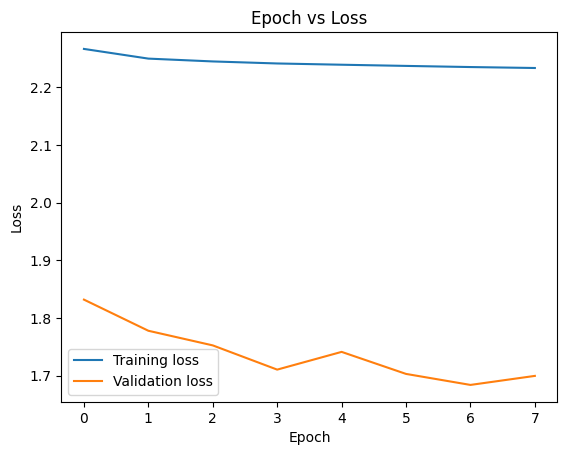

Training Epoch 9:   0%|          | 2/600 [00:00<00:52, 11.29it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 2.162227


Training Epoch 9:  18%|█▊        | 110/600 [00:02<00:08, 60.17it/s]

Train Epoch: 8 [10000/60000 (17%)]	Loss: 2.233160


Training Epoch 9:  35%|███▍      | 208/600 [00:04<00:07, 49.45it/s]

Train Epoch: 8 [20000/60000 (33%)]	Loss: 2.304584


Training Epoch 9:  51%|█████▏    | 308/600 [00:06<00:08, 35.44it/s]

Train Epoch: 8 [30000/60000 (50%)]	Loss: 2.247649


Training Epoch 9:  68%|██████▊   | 411/600 [00:08<00:03, 57.92it/s]

Train Epoch: 8 [40000/60000 (67%)]	Loss: 2.236840


Training Epoch 9:  84%|████████▍ | 506/600 [00:10<00:02, 44.87it/s]

Train Epoch: 8 [50000/60000 (83%)]	Loss: 2.187341


Validation: 100%|██████████| 100/100 [00:02<00:00, 39.20it/s]


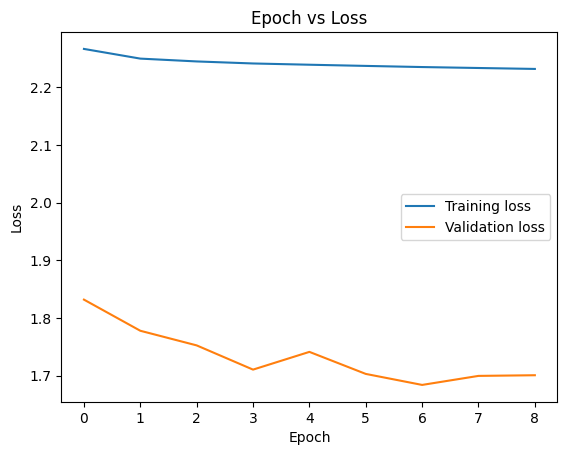

Training Epoch 10:   1%|▏         | 8/600 [00:00<00:16, 36.55it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 2.225062


Training Epoch 10:  18%|█▊        | 111/600 [00:02<00:08, 60.67it/s]

Train Epoch: 9 [10000/60000 (17%)]	Loss: 2.215946


Training Epoch 10:  35%|███▌      | 211/600 [00:03<00:06, 60.55it/s]

Train Epoch: 9 [20000/60000 (33%)]	Loss: 2.249925


Training Epoch 10:  52%|█████▏    | 309/600 [00:05<00:05, 56.26it/s]

Train Epoch: 9 [30000/60000 (50%)]	Loss: 2.226473


Training Epoch 10:  69%|██████▉   | 415/600 [00:07<00:02, 62.60it/s]

Train Epoch: 9 [40000/60000 (67%)]	Loss: 2.255931


Training Epoch 10:  84%|████████▍ | 506/600 [00:09<00:02, 32.41it/s]

Train Epoch: 9 [50000/60000 (83%)]	Loss: 2.240137


Validation: 100%|██████████| 100/100 [00:02<00:00, 37.42it/s]


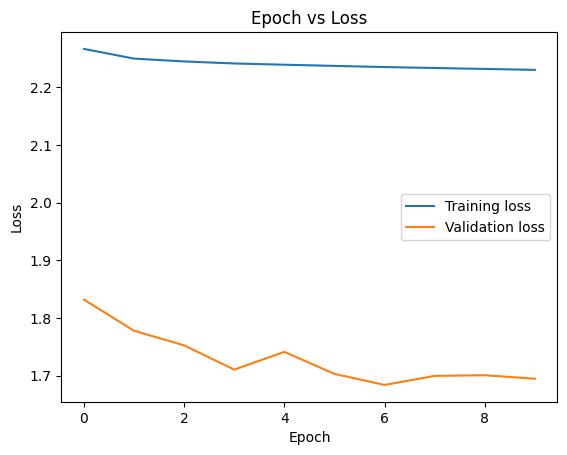

In [ ]:
#training loop

best_val_loss = float('inf')
losses = {"train": [], "val": []}

for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss, preds, labels = validate(criterion, model, val_loader)

    losses["train"].append(train_loss)
    losses["val"].append(val_loss)

    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Update plot every epoch (or consider doing this less often)
    plt.figure()
    plt.plot(losses["train"], label="Training loss")
    plt.plot(losses["val"], label="Validation loss")
    plt.title("Epoch vs Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.pause(0.000001)
    plt.show()



Validation: 100%|██████████| 100/100 [00:01<00:00, 67.73it/s]



Final Metrics:
Accuracy: 80.68%
Recall: 80.68%
F1-score: 80.37%


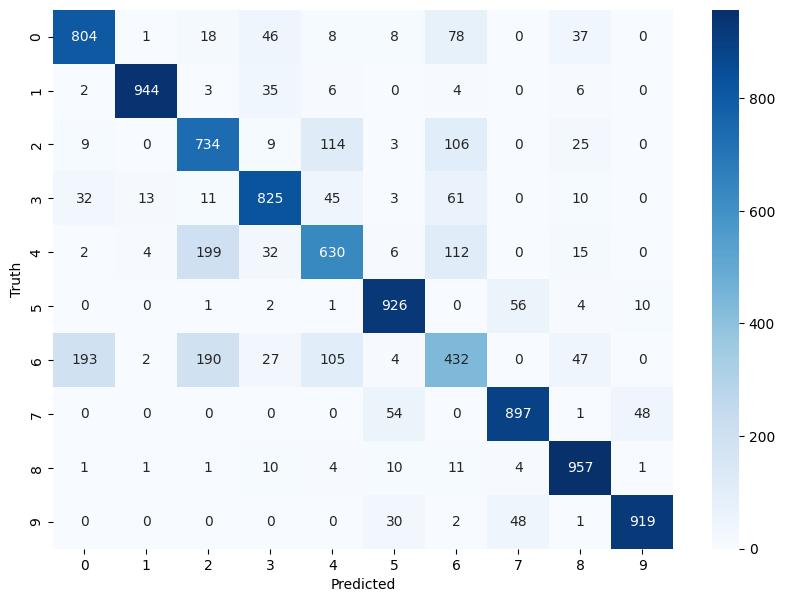

In [ ]:
final_val_loss, all_preds, all_labels = validate(criterion, model, val_loader)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
cm = confusion_matrix(all_labels, all_preds)

# Print metrics
print(f'\nFinal Metrics:')
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1-score: {f1*100:.2f}%')

# Plot confusion matrix using
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


## **CONCLUSIONS ON EXERCISE 4**


Cluster then label approach turned out to get quite impressive results that I didn´t actually expect in the beginning. I tried both Kmeans and Mini Batch Kmeans and Kmeans turned out to hit actually good results. I think the key was that unlike the self-supervised methods in previous exercise, here I made kmeans "classify" or "assign cluster" for every single datapoint. This although made the last asignations of kmeans quite bad, but we had a big amount of well classified ones so this noise in the data didn´t affect that much. Also I believe that Kmeans clustering is quite a powerfull tool. About MBK-means, it´s nice to speed up the process but is not that great for performance. This were the results when training the CNN on the Kmeans generated labels:


*   Accuracy: 80.68%
*   Recall: 80.68%
*   F1-score: 80.37%

As an interesting fact, a very curious think that happened is that the model seem to not be learning a lot, as we can spot on the training loss, but still was outperforming itself each epoch on the validation loss, this might be attached to the work done on the kmeans, which made the training process easier as it could learn the main patterns fast enough to not be even almost noticeable and still get great results.


## Webography
- [Semi-supervised k-means](https://www.kaggle.com/code/dhruv8680/semi-supervised-learning-mnist-dataset-kmeans)

- [K-Means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- [Semi-Supervised Learning](https://scikit-learn.org/stable/modules/label_propagation.html)
- [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)
- [Torchvision Documentation](https://pytorch.org/vision/stable/index.html)
- [Fashion-MNIST Dataset on GitHub](https://github.com/zalandoresearch/fashion-mnist)
- [Fashion-MNIST Dataset on Kaggle](https://www.kaggle.com/zalando-research/fashionmnist)
- [scikit-learn Clustering](https://scikit-learn.org/stable/modules/clustering.html)
- [Semi-Supervised Learning in Python](https://scikit-learn.org/stable/modules/label_propagation.html)
- [Matplotlib Documentation](https://matplotlib.org/stable/contents.html)
- [Seaborn Documentation](https://seaborn.pydata.org/)
- [Introduction to Different Types of Convolutions in Deep Learning](https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215)
- [CNN Architectures: LeNet, AlexNet, VGG, GoogLeNet, ResNet and more](https://towardsdatascience.com/cnn-architectures-le-net-alexnet-vgg-googlenet-resnet-and-more-666091488df5)
- [Scikit-learn Metrics and Scoring](https://scikit-learn.org/stable/modules/model_evaluation.html)
- [Confusion Matrix Visualization](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)
- [Overview of Gradient Descent Optimization Algorithms](https://ruder.io/optimizing-gradient-descent/)
- [Understanding Learning Rates and How It Improves Performance in Deep Learning](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10)
- [Stack Overflow](https://stackoverflow.com/)
- [PyTorch Forums](https://discuss.pytorch.org/)
- [Reddit r/MachineLearning](https://www.reddit.com/r/MachineLearning/)
